In [1]:
import sys
import time
import logging
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", 50)

In [3]:
logging.basicConfig(
    stream=sys.stdout,
    format="%(levelname)s %(asctime)s - %(message)s",
    level=logging.INFO)
logger = logging.getLogger()

# Import customer data

In [4]:
df_cust = pd.read_csv("./data/external/customers.csv")
df_cust["customer_id"] = df_cust["customer_id"].map(str)
df_cust.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [5]:
df_cust.shape

(5000, 3)

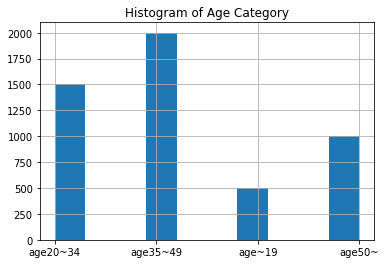

In [6]:
df_cust["age_cat"].hist()
plt.title("Histogram of Age Category")
plt.show()

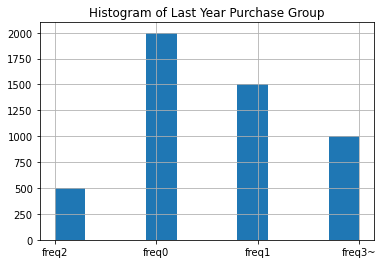

In [7]:
df_cust["freq_cat"].hist()
plt.title("Histogram of Last Year Purchase Group")
plt.show()

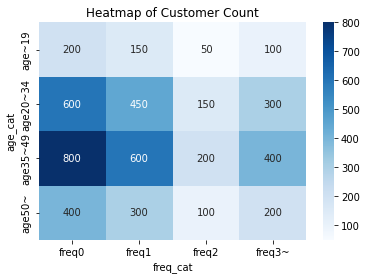

In [8]:
df_cust_pivot = pd.pivot_table(data=df_cust, values='customer_id', columns='freq_cat',
                               index='age_cat', aggfunc='count')\
                  .reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
sns.heatmap(df_cust_pivot, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap of Customer Count")
plt.show()

# Import conversion probability data

In [9]:
df_prob = pd.read_csv("./data/external/visit_probability.csv")
df_prob["segment_id"] = df_prob["segment_id"].map(str)
df_prob

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


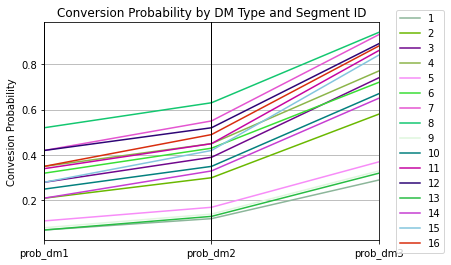

In [10]:
ax = plt.axes()
pd.plotting.parallel_coordinates(
    df_prob[["segment_id", "prob_dm1",
             "prob_dm2", "prob_dm3"]],
    class_column="segment_id")
ax.legend(
    loc="center left", 
    bbox_to_anchor=[1.05, 0.5],
    borderaxespad=0)
ax.set_ylabel("Convesion Probability")
plt.title("Conversion Probability by DM Type and Segment ID")
plt.show()

# Append probability data to customer data

In [11]:
ls_dm = [c.split("_")[-1] for c in df_prob.columns if "prob_dm" in c]

df_prob_long = df_prob\
    .rename(columns=dict(zip(["prob_" + dm for dm in ls_dm], ls_dm)))\
    .melt(id_vars=['segment_id'], value_vars=ls_dm,
          var_name='dm', value_name='prob')

df_cust_prob = df_cust.merge(df_prob, on=["age_cat", "freq_cat"])
df_cust_prob.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93


# Optimization using PuLP

In [12]:
# Create necessary lists.
ls_cust = [c for c in df_cust["customer_id"].unique()]
ls_age_cat = [c for c in df_prob["age_cat"].unique()]
ls_freq_cat = [c for c in df_prob["freq_cat"].unique()]
ls_segment_id = [s for s in df_prob["segment_id"].unique()]
ls_dm = [c.split("_")[-1] for c in df_prob.columns if "prob_dm" in c]

In [13]:
# Create necessary dictionaries.
dict_segment_dm_prob = df_prob_long.set_index(
    ['segment_id','dm'])['prob'].to_dict()
dict_segment_count = df_cust_prob.groupby(
    ["segment_id"])["customer_id"].count().to_dict()

In [14]:
# Create variables to hold exogenous variables.
dict_dm_cost = {"dm1": 0, "dm2": 10, "dm3": 20}
max_budget = 10000
unit_sales = 30
min_dist_ratio = 0.1

In [15]:
# Define optimization problem.
prob = pulp.LpProblem(name="CouponProblem", sense=pulp.LpMaximize)

In [16]:
# Set decision variables
x_sd = {}
for s in ls_segment_id:
    for d in ls_dm:
        x_sd[s, d] = pulp.LpVariable(
            name=f"x({s}, {d})", lowBound=0, upBound=1,
            cat="Continuous")

In [17]:
# Objective: maximize profit
prob += \
    pulp.lpSum(
        dict_segment_dm_prob[s, d] * x_sd[s, d] * dict_segment_count[s] * unit_sales
        for s in ls_segment_id
        for d in ls_dm) - \
    pulp.lpSum(
        dict_segment_dm_prob[s, d] * x_sd[s, d] * dict_segment_count[s] * dict_dm_cost.get(d, 0)
        for s in ls_segment_id
        for d in ls_dm)

In [18]:
# Constraint1: Every customer receives one type of direct mail.
for s in ls_segment_id:
    prob += pulp.lpSum(x_sd[s, d] for d in ls_dm) == 1

In [19]:
# Constraint2: Expectation of total coupon redeem is max_budget or less.
prob += pulp.lpSum(
    x_sd[s, d] * dict_dm_cost.get(d, 0) \
    * dict_segment_dm_prob[s, d] * dict_segment_count[s]
    for s in ls_segment_id
    for d in ls_dm) <= max_budget

In [20]:
# Constraint3: Each type of direct mail is sent to more than or
# equal to 10% of customers of each segment.
for s in ls_segment_id:
    for d in ls_dm:
        prob += x_sd[s, d] >= min_dist_ratio

In [21]:
# Solve optimization
time_start = time.time()
status = prob.solve()
logger.info(f"status: {pulp.LpStatus[status]}")
time_stop = time.time()
logger.info(f"Obj Value: {pulp.value(prob.objective):.4}")
logger.info(f"Compute Time: {(time_stop - time_start):.3}(s)")

INFO 2022-05-18 01:36:27,684 - status: Optimal
INFO 2022-05-18 01:36:27,684 - Obj Value: 3.466e+04
INFO 2022-05-18 01:36:27,684 - Compute Time: 0.191(s)


In [22]:
# Store output to pd.DataFrame
df_send_dm = pd.DataFrame([[x_sd[s, d].value() for d in ls_dm]
                           for s in ls_segment_id],
                          columns=["send_prob_" + dm for dm in ls_dm])
df_seg_send_prob = pd.concat([
    df_prob[["segment_id", "age_cat", "freq_cat"] + ["prob_" + dm for dm in ls_dm]], df_send_dm],
    axis=1)
df_seg_send_prob["num_cust"] = df_seg_send_prob["segment_id"]\
                               .apply(lambda x: dict_segment_count[x])
for dm in ls_dm:
    df_seg_send_prob["num_send_" + dm] = \
        df_seg_send_prob["send_prob_" + dm] * \
        df_seg_send_prob['num_cust']
for dm in ls_dm:
    df_seg_send_prob["num_conversion_" + dm] = \
        df_seg_send_prob["prob_" + dm] * \
        df_seg_send_prob["num_send_" + dm]
df_seg_send_prob["num_conversion_statusquo"] = \
    df_seg_send_prob["num_cust"] * df_seg_send_prob["prob_dm1"]
for dm in ls_dm:
    df_seg_send_prob["val_coupon_redeem_" + dm] = \
        df_seg_send_prob["num_conversion_" + dm] * \
        dict_dm_cost[dm]
df_seg_send_prob["val_sales"] = \
    df_seg_send_prob[["num_conversion_" + dm for dm in dict_dm_cost.keys()]].sum(axis=1) * unit_sales
df_seg_send_prob["val_profit"] = \
    df_seg_send_prob["val_sales"] - \
    df_seg_send_prob[["val_coupon_redeem_" + dm for dm in dict_dm_cost.keys()]].sum(axis=1)
df_seg_send_prob["val_profit_status_quo"] = \
    df_seg_send_prob["num_conversion_statusquo"] * (unit_sales - dict_dm_cost["dm1"])
df_seg_send_prob["val_inc_profit"] = \
    df_seg_send_prob["val_profit"] - df_seg_send_prob["val_profit_status_quo"]
    
df_seg_send_prob

,segment_id,age_cat,freq_cat,prob_dm1,prob_dm2,prob_dm3,send_prob_dm1,send_prob_dm2,send_prob_dm3,num_cust,num_send_dm1,num_send_dm2,num_send_dm3,num_conversion_dm1,num_conversion_dm2,num_conversion_dm3,num_conversion_statusquo,val_coupon_redeem_dm1,val_coupon_redeem_dm2,val_coupon_redeem_dm3,val_sales,val_profit,val_profit_status_quo,val_inc_profit
0,1,age~19,freq0,0.07,0.12,0.29,0.1,0.800000,0.100000,200,20.0,160.000000,20.000000,1.4,19.200000,5.800000,14.0,0.0,192.000000,116.000000,792.000000,484.000000,420.0,6.400000e+01
1,2,age~19,freq1,0.21,0.30,0.58,0.8,0.100000,0.100000,150,120.0,15.000000,15.000000,25.2,4.500000,8.700000,31.5,0.0,45.000000,174.000000,1152.000000,933.000000,945.0,-1.200000e+01
2,3,age~19,freq2,0.28,0.39,0.74,0.8,0.100000,0.100000,50,40.0,5.000000,5.000000,11.2,1.950000,3.700000,14.0,0.0,19.500000,74.000000,505.500000,412.000000,420.0,-8.000000e+00
3,4,age~19,freq3~,0.35,0.45,0.77,0.8,0.100000,0.100000,100,80.0,10.000000,10.000000,28.0,4.500000,7.700000,35.0,0.0,45.000000,154.000000,1206.000000,1007.000000,1050.0,-4.300000e+01
4,5,age20~34,freq0,0.11,0.17,0.37,0.8,0.100000,0.100000,600,480.0,60.000000,60.000000,52.8,10.200000,22.200000,66.0,0.0,102.000000,444.000000,2556.000000,2010.000000,1980.0,3.000000e+01
5,6,age20~34,freq1,0.32,0.43,0.72,0.8,0.100000,0.100000,450,360.0,45.000000,45.000000,115.2,19.350000,32.400000,144.0,0.0,193.500000,648.000000,5008.500000,4167.000000,4320.0,-1.530000e+02
6,7,age20~34,freq2,0.42,0.55,0.93,0.8,0.100000,0.100000,150,120.0,15.000000,15.000000,50.4,8.250000,13.950000,63.0,0.0,82.500000,279.000000,2178.000000,1816.500000,1890.0,-7.350000e+01
7,8,age20~34,freq3~,0.52,0.63,0.94,0.8,0.100000,0.100000,300,240.0,30.000000,30.000000,124.8,18.900000,28.200000,156.0,0.0,189.000000,564.000000,5157.000000,4404.000000,4680.0,-2.760000e+02
8,9,age35~49,freq0,0.08,0.14,0.33,0.1,0.800000,0.100000,800,80.0,640.000000,80.000000,6.4,89.600000,26.400000,64.0,0.0,896.000000,528.000000,3672.000000,2248.000000,1920.0,3.280000e+02
9,10,age35~49,freq1,0.25,0.35,0.67,0.8,0.100000,0.100000,600,480.0,60.000000,60.000000,120.0,21.000000,40.200000,150.0,0.0,210.000000,804.000000,5436.000000,4422.000000,4500.0,-7.800000e+01


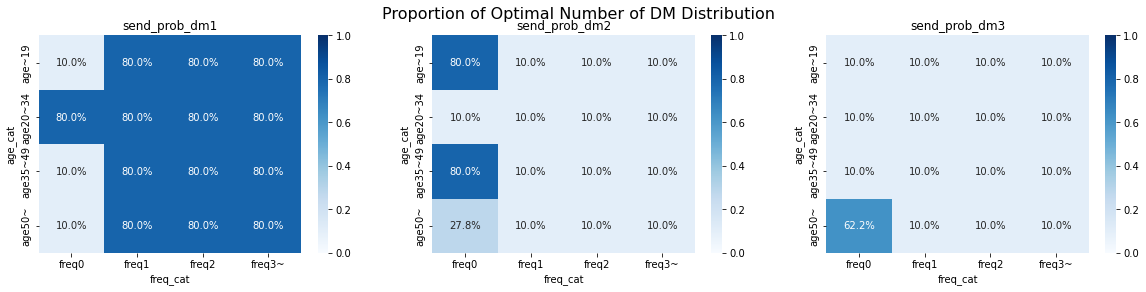

In [23]:
# Visualize results
len_ls_dm = len(ls_dm)

ax = {}
fig, ax = \
    plt.subplots(1, len_ls_dm, figsize=(20, 4))
for i, ptn in enumerate(["send_prob_" + dm for dm in ls_dm]):
    df_seg_send_pivot = pd.pivot_table(
        data=df_seg_send_prob, values=ptn, columns="freq_cat", 
        index="age_cat", aggfunc="mean")
    df_seg_send_pivot = df_seg_send_pivot.reindex(ls_age_cat)
    sns.heatmap(
        df_seg_send_pivot, annot=True, fmt=".1%", cmap="Blues", 
        vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f"{ptn}")
fig.suptitle("Proportion of Optimal Number of DM Distribution", fontsize=16)
plt.show()

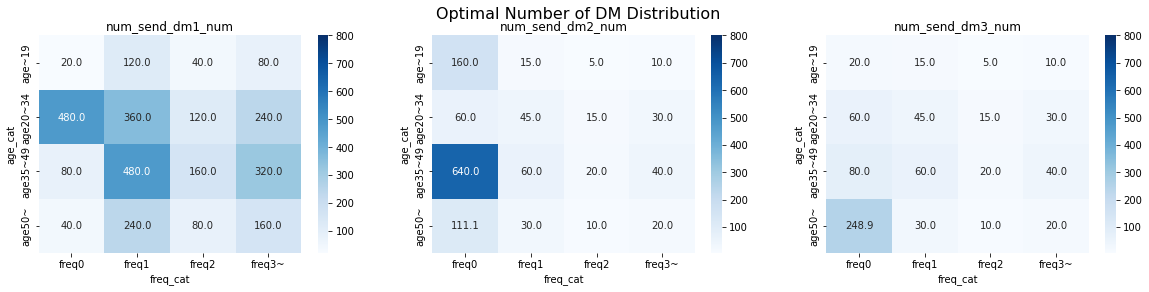

In [24]:
ax = {}
fig, ax = \
    plt.subplots(1, len_ls_dm, figsize=(20, 4))
for i, ptn in enumerate(["num_send_" + dm for dm in ls_dm]):
    df_cust_send_pivot = pd.pivot_table(
        data=df_seg_send_prob, values=ptn, columns="freq_cat",
        index="age_cat", aggfunc="sum")
    df_cust_send_pivot = df_cust_send_pivot.reindex(ls_age_cat)
    sns.heatmap(
        df_cust_send_pivot, annot=True, fmt=".1f", cmap="Blues",
        vmax=800, ax=ax[i])
    ax[i].set_title(f"{ptn}_num")
fig.suptitle("Optimal Number of DM Distribution", fontsize=16)
plt.show()